In [1]:
import numpy as np
import scipy


import kwant

import holoviews as hv
hv.notebook_extension()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

#### check kwant version and use proper vector factory

In [2]:
from functools import partial
from codes.kpm_funcs import build_greens_function, build_perturbation, proj, exact_greens_function

### definition of initial Hamiltonian and perturbation

In [3]:
def H0_random(nA=4, nB=100, gap=1, epsilonA=0.2, epsilonB=10):
    """Generate random Hamiltonian with quasi-degenerate states."""
    energiesA = epsilonA * np.random.random(nA) - epsilonA / 2
    
    energiesB = epsilonB * np.random.random(nB) - epsilonB / 2
    energiesB = energiesB[np.abs(energiesB) > gap/2]

    energies = np.append(energiesA, energiesB)
    U = kwant.rmt.circular(len(energies))
    
    return np.diag(energies)#U.transpose().conjugate() @ np.diag(energies) @ U


def H1_random(n, v=0.1):
    return kwant.rmt.gaussian(n, v=v)

alphas = np.linspace(0, 1, 100)
np.random.seed(1)

H0 = H0_random()        # This is H_0
H1 = H1_random(len(H0)) # This is perturbation (H')

energies = []
for alpha in alphas:
    e = np.linalg.eigh(H0 + alpha * H1)[0]
    energies.append(e)

In [4]:
H0.shape

(98, 98)

In [5]:
window = (-.25, +.25)
eigenvalues0, evec = np.linalg.eigh(H0)

indices = [i for (i, e) in enumerate(eigenvalues0) if window[0] < e < window[1]]
n = len(indices)

In [6]:
bounds = (np.min(eigenvalues0)-0.05, np.max(eigenvalues0) + 0.05)

:Path   [x,y]
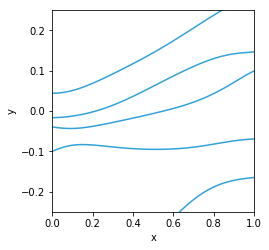

In [7]:
hv.Path((alphas, energies))[:,window[0]:window[1]]

### kpm greens function

### compare with exact calculation of Green's funciton

In [8]:
init_vector = np.exp(2j*np.pi*np.random.rand(2, H0.shape[0]))
# init_vector = init_vector / np.linalg.norm(init_vector)

In [9]:
energies = np.linspace(bounds[0],bounds[1],200)

In [10]:
e = 0

g_exact = exact_greens_function(H0)
expanded_init_vector_exact = g_exact(init_vector, [e]*init_vector.shape[0])

In [11]:
init_vector.shape, expanded_init_vector_exact.shape

((2, 98), (2, 98))

In [12]:
g_kpm = build_greens_function(H0, vectors=init_vector,
                              kpm_params=dict(
                                  bounds=bounds,
                                  num_moments=600)
                             )
expanded_init_vectors_kpm = g_kpm(e)

In [13]:
expanded_init_vectors_kpm.shape

(2, 98)

In [14]:
# average quotient of the two vectors
np.mean(expanded_init_vector_exact/expanded_init_vectors_kpm, axis=1)

array([ 0.99276675+0.00547043j,  0.99276675+0.00547043j])

#### compare absolute value and phase for the Green's function applied to one vector 

In [15]:
expanded_init_vector_exact.shape, expanded_init_vectors_kpm.shape

((2, 98), (2, 98))

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)
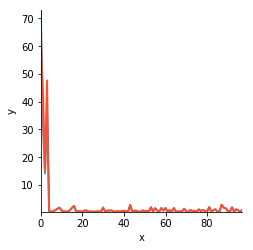

In [16]:
hv.Curve(np.linalg.norm(expanded_init_vector_exact, axis=0)) * hv.Curve(np.linalg.norm(expanded_init_vectors_kpm, axis=0))

:Layout
   .Overlay.I  :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Curve.II :Curve   [x]   (y)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Curve.II :Curve   [x]   (y)
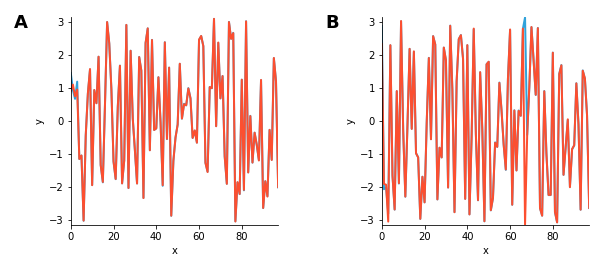

In [17]:
hv.Curve(np.angle(expanded_init_vector_exact[0])) * hv.Curve(np.angle(expanded_init_vectors_kpm[0])) +\
hv.Curve(np.angle(expanded_init_vector_exact[1])) * hv.Curve(np.angle(expanded_init_vectors_kpm[1]))

#### Green's function with exact and kpm methods

:Overlay
   .Path.I    :Path   [x,y]
   .Scatter.I :Scatter   [x]   (y)
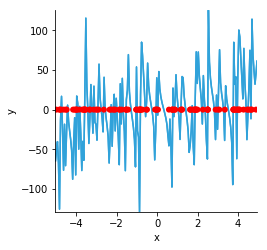

In [18]:
%%opts Scatter (color='r')
g_exact = exact_greens_function(H0)
g_sum_exact = []
for e in energies:
    expanded_vector_exact = g_exact(init_vector, [e]*init_vector.shape[0])
    g_sum_exact.append(np.sum(init_vector.conj() * expanded_vector_exact, axis=1))
g_sum_exact = np.array(g_sum_exact)
hv.Path((energies, g_sum_exact.real)) * hv.Scatter((np.linalg.eigh(H0)[0], [0]*H0.shape[0]))

:Overlay
   .Path.I    :Path   [x,y]
   .Scatter.I :Scatter   [x]   (y)
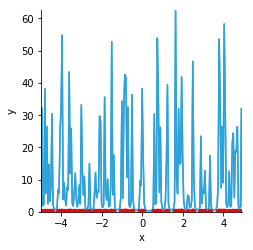

In [19]:
%%opts Scatter (color='r')
# density of states = - 1/pi Im(G)
hv.Path((energies,-1/np.pi*g_sum_exact.imag)) * hv.Scatter((np.linalg.eigh(H0)[0], [0]*H0.shape[0]))

:Overlay
   .Path.I    :Path   [x,y]
   .Scatter.I :Scatter   [x]   (y)
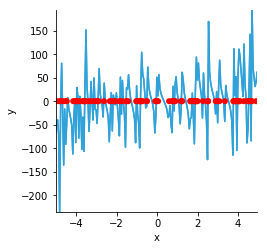

In [20]:
%%opts Scatter (color='r')

g_kpm = build_greens_function(
    H0, vectors=init_vector,
    kpm_params=dict(bounds=bounds, num_moments=1000))

g_sum_kpm = []
for e in energies:
    expanded_vectors_kpm = g_kpm(e)
    g_sum_kpm.append(np.sum(init_vector.conj() * expanded_vectors_kpm, axis=1) )
g_sum_kpm = np.array(g_sum_kpm)
hv.Path((energies, g_sum_kpm.real))[:,:] * hv.Scatter((np.linalg.eigh(H0)[0], [0]*H0.shape[0]))

:Overlay
   .Path.I    :Path   [x,y]
   .Scatter.I :Scatter   [x]   (y)
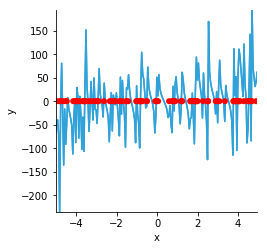

In [21]:
%%opts Scatter (color='r')

g_kpm = build_greens_function(
    H0, vectors=init_vector,
    kpm_params=dict(bounds=bounds, num_moments=1000))

g_sum_kpm = []
expanded_vectors_kpm = g_kpm(energies)
g_sum_kpm = np.sum(init_vector.conj()[None,] * expanded_vectors_kpm, axis=2)
hv.Path((energies, g_sum_kpm.real))[:,:] * hv.Scatter((np.linalg.eigh(H0)[0], [0]*H0.shape[0]))

In [22]:
expanded_vectors_kpm.shape, g_sum_kpm.shape

((200, 2, 98), (200, 2))

:Overlay
   .Path.I    :Path   [x,y]
   .Scatter.I :Scatter   [x]   (y)
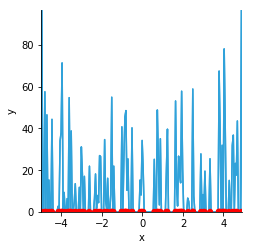

In [23]:
%%opts Scatter (color='r')
# density of states = -1\pi Im(G)
hv.Path((energies, -1/np.pi*g_sum_kpm.imag)) * hv.Scatter((np.linalg.eigh(H0)[0], [0]*H0.shape[0]))

#### build projectors over a subspace

In [24]:
window = (-.25, +.25)
eigenvalues0, evec = np.linalg.eigh(H0)

indices = [i for (i, e) in enumerate(eigenvalues0) if window[0] < e < window[1]]
n = len(indices)

In [25]:
eigs_subspace = eigenvalues0[indices]
vecs_subspace = evec[:, indices].T
init_vector = (H1 @ vecs_subspace.T).T #np.exp(2j*np.pi*np.random.rand(1, H0.shape[0]))

In [26]:
init_vector.shape, vecs_subspace.shape

((4, 98), (4, 98))

In [27]:
proj(init_vector, vecs_subspace).shape

(4, 98)

In [28]:
init_vector.shape

(4, 98)

:Scatter   [x]   (y)
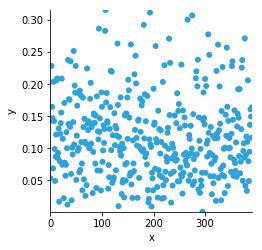

In [29]:
hv.Scatter(np.abs(init_vector).flatten())

:Scatter   [x]   (y)
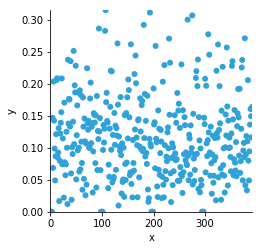

In [30]:
hv.Scatter(np.abs(proj(init_vector, vecs_subspace)).flatten())

In [31]:
np.linalg.norm(proj(init_vector, vecs_subspace))

2.6111337585300154

### perturbation elements of the matrix

In [32]:
eigenvalues0, psi0 = np.linalg.eigh(H0)
kpm_params = dict(num_moments=1000, bounds=(-5,5))

In [33]:
eigenvalues0[indices]

array([-0.09997713, -0.03953349, -0.0165956 ,  0.0440649 ])

In [34]:
psi0[:,indices].shape

(98, 4)

In [35]:
hij2 = build_perturbation(eigenvalues0[indices], psi0[:,indices].T, H0, H1, kpm_params=kpm_params)

In [36]:
hij2.shape

(4, 4)

In [37]:
np.allclose(hij2, hij2.conj().T)

True

In [38]:
hij2

array([[-0.04922834+0.j        , -0.15631297+0.07870162j,
         0.08802311-0.09722191j,  0.02249981-0.08912773j],
       [-0.15631297-0.07870162j,  0.31612433+0.j        ,
         0.13883129-0.12265745j, -0.03327408+0.07837973j],
       [ 0.08802311+0.09722191j,  0.13883129+0.12265745j,
         0.31255472+0.j        ,  0.06038745-0.07125585j],
       [ 0.02249981+0.08912773j, -0.03327408-0.07837973j,
         0.06038745+0.07125585j,  0.07830877+0.j        ]])

#### apply to a specific realization of $H_0$ and $H$

In [39]:
eigenvalues0, psi0 = np.linalg.eigh(H0)

In [40]:
rescaled_ham, (a0, b0) = kwant.kpm._rescale(H0, 0.0005, None, None)
rescaled_ham, (a1, b1) = kwant.kpm._rescale(H0 + H1, 0.0005, None, None)

In [41]:
a0, a1, b0, b1

(4.9311865467617126,
 5.8031330907604417,
 -0.04134295182679537,
 -0.10918291479442432)

In [42]:
kpm_params = dict(bounds=(b0-a0, a0+b0))

In [43]:
eigenvalues, psi = np.linalg.eigh(H0 + H1)

In [44]:
window = (-.25, +.25)
ev, evec = np.linalg.eigh(H0)

indices = [i for (i, e) in enumerate(ev) if window[0] < e < window[1]]
n = len(indices)

#### first order correction

In [45]:
hij1 = psi0[:,indices].conj().T @ (H1 @ psi0[:,indices])

In [46]:
hij1.shape

(4, 4)

In [47]:
np.allclose(hij1, hij1.conj().T)

True

#### second order correction

In [48]:
kpm_params

{'bounds': (-4.972529498588508, 4.8898435949349173)}

In [49]:
kpm_params['num_moments'] = 1000

In [50]:
hij2 = build_perturbation(eigenvalues0[indices], psi0[:,indices].T, H0, H1, kpm_params=kpm_params)

In [51]:
hij2.shape

(4, 4)

In [52]:
np.allclose(hij2, hij2.conj().T)

True

In [53]:
hij2

array([[-0.04922953+0.j        , -0.15630998+0.07870233j,
         0.08802452-0.09722088j,  0.02250002-0.08912822j],
       [-0.15630998-0.07870233j,  0.31612076+0.j        ,
         0.13882845-0.12265506j, -0.03327356+0.07837947j],
       [ 0.08802452+0.09722088j,  0.13882845+0.12265506j,
         0.31255225+0.j        ,  0.06038665-0.07125465j],
       [ 0.02250002+0.08912822j, -0.03327356-0.07837947j,
         0.06038665+0.07125465j,  0.07830780+0.j        ]])

In [54]:
h_eff = np.diag(eigenvalues0[indices]) + hij1 + hij2

In [55]:
e_eff, psi_eff = np.linalg.eigh(h_eff)

In [56]:
# h1_eff and h2_eff

eigs_exact = []
eigs_eff1 = []
eigs_eff2 = []
alphas = np.logspace(-8, 0, 200)
for alpha in alphas:
    eigs_exact.append(np.linalg.eigh(H0 + alpha * H1)[0][indices])
    eigs_eff1.append(np.linalg.eigh(np.diag(ev[indices])+
                                   alpha * hij1
                                  )[0]
                   )
    eigs_eff2.append(np.linalg.eigh(np.diag(ev[indices])+
                                   alpha * hij1 +
                                   alpha**2 * hij2
                                  )[0]
                   )
eigs_exact = np.array(eigs_exact)
eigs_eff1 = np.array(eigs_eff1)
eigs_eff2 = np.array(eigs_eff2)

:Overlay
   .Path.I   :Path   [$\alpha$,$\epsilon$]
   .Path.II  :Path   [$\alpha$,$\epsilon$]
   .Path.III :Path   [$\alpha$,$\epsilon$]
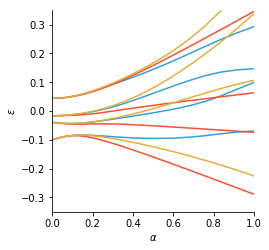

In [57]:
(
    hv.Path((alphas, eigs_exact), kdims=[r'$\alpha$', r'$\epsilon$']) *
    hv.Path((alphas, eigs_eff1), kdims=[r'$\alpha$', r'$\epsilon$']) *
    hv.Path((alphas, eigs_eff2), kdims=[r'$\alpha$', r'$\epsilon$'])
)[:,-0.35:0.35]

:Overlay
   .Path.I  :Path   [$\alpha$,diff]
   .Path.II :Path   [$\alpha$,diff]
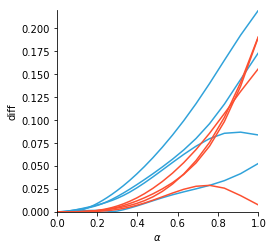

In [58]:
%%opts Overlay [logy=False]
(
    hv.Path((alphas, np.abs(eigs_exact-eigs_eff1)),
           kdims=[r'$\alpha$', 'diff']) *
    hv.Path((alphas, np.abs(eigs_exact-eigs_eff2)),
           kdims=[r'$\alpha$', 'diff'])
)[:,1e-8:]

:Overlay
   .Path.I  :Path   [$\alpha$,diff]
   .Path.II :Path   [$\alpha$,diff]
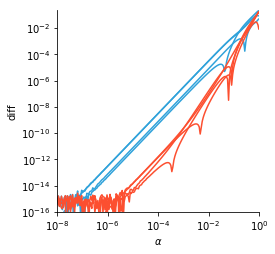

In [59]:
%%opts Overlay [logx=True logy=True]
(
    hv.Path((alphas, np.abs(eigs_exact-eigs_eff1)),
           kdims=[r'$\alpha$', 'diff']) *
    hv.Path((alphas, np.abs(eigs_exact-eigs_eff2)),
            kdims=[r'$\alpha$', 'diff'])
)[1e-8:,1e-16:]